## Master of Applied Data Science
### University of Michigan - School of Information
### Capstone Project - Rapid Labeling of Text Corpus Using Information Retrieval Techniques
### Fall 2021
#### Team Members: 
Chloe Zhang ([chloexyz@umich.edu](chloexyz@umich.edu)), 
Michael Penrose ([penrosem@umich.edu](penrosem@umich.edu)), 
Carlo Tak ([carlotak@umich.edu](carlotak@umich.edu))

### Experiment Flow

event type > count vectorizer > unigrams > feature selection > 100 features > PyCaret

### Purpose

This notebook investigates how well a classifier can predict the **event type (i.e. 'earthquake', 'fire', 'flood', 'hurricane)** of the Tweets in the [Disaster tweets dataset](https://crisisnlp.qcri.org/humaid_dataset.html#) (Firoj Alam, Umair Qazi, Muhammad Imran and Ferda Ofli, HumAID: Human-Annotated Disaster Incidents Data from Twitter, In ICWSM, 2021).

This classifier was built as an initial exploration of what is possible. Two things are investigated:
- Is it possible to build a reasonable 'good' classifier of these tweets at all
- If it is possible to build a classifier how well does the classifier perform using all of the labels from the training data

If it is possible to build a classifier using all of the labels in the training dataset then it should be possible to implement a method for rapidly labeling the corpus of texts in the dataset. Here we think of rapid labeling as any process that does not require the user to label each text in the corpus, one at a time.


### Summary

The classifier built using all the labels in the training dataset produced a classifier (XGBoost) that had a fairly good AUC score for each of the 4 event type labels (i.e. earthquake, fire, flood, hurricane). All the AUC scores were 0.99 or above. Also, the classifier produced had an accuracy of 0.9659.

A simple vectorization (of texts) approach was implemented because our feeling was that more complex techniques could be implemented at a later stage. A [count vectorizer]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (with default settings) was used to convert the texts. The number of dimensions (features) was also reduced using feature selection ([SelectKBest]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)). This was to improve computational times – fewer dimensions means that there are fewer data to process. Also, this was a simpler method to implement than other techniques like removing stopwords, adjusting parameters like ‘stop_words’, ‘ngram_range’, ‘max_df’, ‘min_df’, and ‘max_features’.  The complexity of the classifier could be adjusted if required, but this simple implementation produced good results.

This notebook reduced the number of features to 100 using a feature selection technique ([SelectKBest]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)). This reduced the size of the data to process. The features being selected were unigrams (single terms from the text).

The feature importances were extracted from the classifier, to see if they made sense. This sense check was important because we made several assumptions in building this classifier, that had to be validated. For example, when the text was vectorized we used a simple approach that just counted the individual words (tokens) – are more complex classifier might use bi-grams (two words per feature), this would have had the advantage of preserving features like ‘’.

Examining the top features, these seem to be reasonable features to be in the top five, because it does appear to provide some information to be able to distinguish between the 4 possible classes (earthquake, fire, flood, hurricane.


In [1]:
from utilities import dt_utilities as utils
from datetime import datetime

In [2]:
start_time = datetime.now()
start_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/04 08:26:05'

In [3]:
consolidated_disaster_tweet_data_df = \
    utils.get_consolidated_disaster_tweet_data(root_directory="data/",
                                               event_type_directory="HumAID_data_event_type",
                                               events_set_directories=["HumAID_data_events_set1_47K",
                                                                       "HumAID_data_events_set2_29K"],
                                               include_meta_data=True)

In [4]:
consolidated_disaster_tweet_data_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798262465234542592,sympathy_and_support,earthquake,dev,RT @MissEarth: New Zealand need our prayers af...
1,771464543796985856,caution_and_advice,earthquake,dev,"@johnaglass65 @gordonluke Ah, woke up to a nig..."
2,797835622471733248,requests_or_urgent_needs,earthquake,dev,RT @terremotocentro: #eqnz if you need a tool ...
3,798021801540321280,other_relevant_information,earthquake,dev,RT @BarristerNZ: My son (4) has drawn a pictur...
4,798727277794033664,infrastructure_and_utility_damage,earthquake,dev,Due to earthquake damage our Defence Force is ...
...,...,...,...,...,...
76479,783991683188948992,infrastructure_and_utility_damage,hurricane,train,RT @LindsayLogue: 3500+ homes destroyed in Haiti
76480,783794225368276992,not_humanitarian,hurricane,train,"@ClintonFdn stay out of Haiti, you will not ge..."
76481,783399699994648576,other_relevant_information,hurricane,train,Hurricane-hit southern Haiti cut off after bri...
76482,783400762898391041,sympathy_and_support,hurricane,train,Please pray for these beautiful people.


In [5]:
train_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="train"].reset_index(drop=True)
train_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798064896545996801,other_relevant_information,earthquake,train,I feel a little uneasy about the idea of work ...
1,797913886527602688,caution_and_advice,earthquake,train,#eqnz Interislander ferry docking aborted afte...
2,797867944546025472,other_relevant_information,earthquake,train,Much of New Zealand felt the earthquake after ...
3,797958935126773760,sympathy_and_support,earthquake,train,"Noticing a lot of aftershocks on eqnz site, bu..."
4,797813020567056386,infrastructure_and_utility_damage,earthquake,train,"RT @E2NZ: Mike Clements, NZ police, says obvio..."
...,...,...,...,...,...
53526,783991683188948992,infrastructure_and_utility_damage,hurricane,train,RT @LindsayLogue: 3500+ homes destroyed in Haiti
53527,783794225368276992,not_humanitarian,hurricane,train,"@ClintonFdn stay out of Haiti, you will not ge..."
53528,783399699994648576,other_relevant_information,hurricane,train,Hurricane-hit southern Haiti cut off after bri...
53529,783400762898391041,sympathy_and_support,hurricane,train,Please pray for these beautiful people.


In [6]:
test_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="test"].reset_index(drop=True)
test_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798274825441538048,infrastructure_and_utility_damage,earthquake,test,The earthquake in New Zealand was massive. Bil...
1,798452064208568320,infrastructure_and_utility_damage,earthquake,test,These pictures show the alarming extent of the...
2,797804396767682560,sympathy_and_support,earthquake,test,Just woke to news of another earthquake! WTF N...
3,798434862830993408,not_humanitarian,earthquake,test,"When theres an actual earthquake, landslide an..."
4,797790705414377472,caution_and_advice,earthquake,test,"Tsunami warning for entire East Coast of NZ, b..."
...,...,...,...,...,...
15155,783985895493865472,caution_and_advice,hurricane,test,RT @rolandsmartin: 7AM ET on #NewsOneNow: Hurr...
15156,783746504129294336,sympathy_and_support,hurricane,test,RT @ILiveBeyond: Please pray for the people of...
15157,783864123167608832,injured_or_dead_people,hurricane,test,Hurricane Matthew kills 26 in Caribbean on des...
15158,783528309963579392,injured_or_dead_people,hurricane,test,An already struggling Haiti faced massive Hurr...


In [7]:
dev_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="dev"].reset_index(drop=True)
dev_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798262465234542592,sympathy_and_support,earthquake,dev,RT @MissEarth: New Zealand need our prayers af...
1,771464543796985856,caution_and_advice,earthquake,dev,"@johnaglass65 @gordonluke Ah, woke up to a nig..."
2,797835622471733248,requests_or_urgent_needs,earthquake,dev,RT @terremotocentro: #eqnz if you need a tool ...
3,798021801540321280,other_relevant_information,earthquake,dev,RT @BarristerNZ: My son (4) has drawn a pictur...
4,798727277794033664,infrastructure_and_utility_damage,earthquake,dev,Due to earthquake damage our Defence Force is ...
...,...,...,...,...,...
7788,783947842092138497,rescue_volunteering_or_donation_effort,hurricane,dev,U.S. Nonprofit All Hands Volunteers Heads To H...
7789,783838361425440768,other_relevant_information,hurricane,dev,RT @Aaylin_xoxo: It breaks my heart to see how...
7790,783860660388007937,other_relevant_information,hurricane,dev,TBH nobody know what hurricane Mathew gone do ...
7791,784689762032508928,injured_or_dead_people,hurricane,dev,Hurricane Matthew Barrels Up The East Coast Af...


The training data is examined, and the number of records for each 'event_type' is shown below.

In [8]:
train_df.groupby(["event_type"]).size().reset_index().rename(columns={0: "Count"}).sort_values("Count", ascending=False)

,event_type,Count
3,hurricane,31674
2,flood,7815
1,fire,7792
0,earthquake,6250


It can be seen that 'hurricane' has the most number of records.

The training data is examined, and the number of records for each 'class_label' is shown below.

In [9]:
train_df.groupby(["class_label"]).size().reset_index().rename(columns={0: "Count"}).sort_values("Count", ascending=False)

,class_label,Count
8,rescue_volunteering_or_donation_effort,14891
6,other_relevant_information,8501
9,sympathy_and_support,6250
2,infrastructure_and_utility_damage,5715
3,injured_or_dead_people,5110
5,not_humanitarian,4407
0,caution_and_advice,3774
1,displaced_people_and_evacuations,2800
7,requests_or_urgent_needs,1833
4,missing_or_found_people,250


It can be seen that 'rescue_volunteering_or_donation_effort' has the most records. 'missing_or_found_people' has the least number of records. This label has less than 1000 examples. This might negatively affect the performance of the classifier with these labels.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.sparse import coo_matrix, hstack
import scipy.sparse
import numpy as np
from collections import Counter

In [11]:
num_features = 100
target_column = "event_type"
# vectorizer = TfidfVectorizer(max_features=num_features)
# count_vectorizer = CountVectorizer(max_features=num_features)

vectorizer = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("reduce", SelectKBest(score_func=f_classif, k=num_features)), # chi2, f_classif
])

The number of features was set manually to 100. This was felt to be a good number for the classifier. More features can be used, but it would increase the amount of computation. A good balance of the number of features will have to be reached when the final web application is built because the web application will have to perform well.

A simple CountVectorizer was used to vectorize the tweets. A more sophisticated vectorizer like TfidfVectorizer could be used for the final web application, but to build this classifier, this vectorizer was thought to be sufficient.

In [12]:
vectorizer.fit(train_df["tweet_text"], train_df[target_column])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('reduce', SelectKBest(k=100))])

In [13]:
def vectorized_tweet_data(fitted_vectorizer, source_df, text_column, target_column, 
                          vectorizer_name="vectorizer", reducer_name="reduce"):
    vectorized_data = fitted_vectorizer.transform(source_df[text_column])
    
    vectorized_df = pd.DataFrame.sparse.from_spmatrix(vectorized_data)
    
    all_feature_names = fitted_vectorizer.named_steps[vectorizer_name].get_feature_names()
    support = vectorizer.named_steps[reducer_name].get_support()
    feature_names = np.array(all_feature_names)[support]
    vectorized_df.columns = feature_names

    vectorized_df = vectorized_df.sparse.to_dense()

    # vectorized_df = vectorized_df.apply(pd.to_numeric)
    vectorized_df = vectorized_df.astype(float)

    vectorized_df["tweet_id"] = source_df["tweet_id"]
    vectorized_df["tweet_text"] = source_df["tweet_text"]
    vectorized_df[target_column] = source_df[target_column]

    return vectorized_df

In [14]:
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [15]:
train_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=train_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column, 
                                                       vectorizer_name="vectorizer", 
                                                       reducer_name="reduce")
train_vectorized_event_type_df

,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,californias,camp,campfire,camps,cm,cmokerala,crore,cycloneidai,damage,dead,deadliest,death,dorian,earthquake,ecuador,ecuadorearthquake,ellicott,eqnz,fire,firefighters,fires,flood,flooding,floods,floodsl,florence,florida,forest,fort,fund,greece,greecefires,greek,harvey,history,hurricane,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricanemaria,india,injured,iowa,irma,italy,italyearthquake,kaikoura,kashmir,kerala,keralaflood,keralafloodrelief,keralafloods,keralafloods2018,keralarelieffund,keralasos,magnitude,maria,maryland,materials,mcmurray,mexico,mirpur,missing,nebraska,newzealand,northern,nz,pakistan,paradise,prayforgreece,prayforitaly,puerto,quake,relief,rico,rs,rt,srilanka,standwithkerala,storm,terremoto,the,toll,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,tweet_id,tweet_text,event_type
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798064896545996801,I feel a little uneasy about the idea of work tomorrow when the aftershocks are still so strong. #eqnz #wellingtonearthquake,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797913886527602688,"#eqnz Interislander ferry docking aborted after huge 7.5 magnitude quake, sailings on hold",earthquake
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,797867944546025472,Much of New Zealand felt the earthquake after midnight; waking to discover how much damage,earthquake
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,797958935126773760,"Noticing a lot of aftershocks on eqnz site, but we seem not to be feeling them. What about the rest of Wellington?",earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,797813020567056386,"RT @E2NZ: Mike Clements, NZ police, says obvious damage in places like Wellington, it would take time to check buildings #eqnz",earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [16]:
test_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=test_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column)
test_vectorized_event_type_df

,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,californias,camp,campfire,camps,cm,cmokerala,crore,cycloneidai,damage,dead,deadliest,death,dorian,earthquake,ecuador,ecuadorearthquake,ellicott,eqnz,fire,firefighters,fires,flood,flooding,floods,floodsl,florence,florida,forest,fort,fund,greece,greecefires,greek,harvey,history,hurricane,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricanemaria,india,injured,iowa,irma,italy,italyearthquake,kaikoura,kashmir,kerala,keralaflood,keralafloodrelief,keralafloods,keralafloods2018,keralarelieffund,keralasos,magnitude,maria,maryland,materials,mcmurray,mexico,mirpur,missing,nebraska,newzealand,northern,nz,pakistan,paradise,prayforgreece,prayforitaly,puerto,quake,relief,rico,rs,rt,srilanka,standwithkerala,storm,terremoto,the,toll,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,tweet_id,tweet_text,event_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,798274825441538048,The earthquake in New Zealand was massive. Billions of dollars of damage. And it was followed by a storm.,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the quake damage to this building. Keep well clear!,earthquake
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF NZ?! They seem to be happening an awful lot. Stay safe everyone xx #eqnz,earthquake
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,798434862830993408,"When theres an actual earthquake, landslide and severe flooding during your driving test and you still pass #eqnz #Wellington @NZTAWgtn",earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, be safe people, move to higher ground! #eqnz",earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [17]:
dev_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=dev_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column)
dev_vectorized_event_type_df

,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,californias,camp,campfire,camps,cm,cmokerala,crore,cycloneidai,damage,dead,deadliest,death,dorian,earthquake,ecuador,ecuadorearthquake,ellicott,eqnz,fire,firefighters,fires,flood,flooding,floods,floodsl,florence,florida,forest,fort,fund,greece,greecefires,greek,harvey,history,hurricane,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricanemaria,india,injured,iowa,irma,italy,italyearthquake,kaikoura,kashmir,kerala,keralaflood,keralafloodrelief,keralafloods,keralafloods2018,keralarelieffund,keralasos,magnitude,maria,maryland,materials,mcmurray,mexico,mirpur,missing,nebraska,newzealand,northern,nz,pakistan,paradise,prayforgreece,prayforitaly,puerto,quake,relief,rico,rs,rt,srilanka,standwithkerala,storm,terremoto,the,toll,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,tweet_id,tweet_text,event_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,798262465234542592,RT @MissEarth: New Zealand need our prayers after the devastating earthquake and 2 meter high tsunami waves. #PrayForNewZealand,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,771464543796985856,"@johnaglass65 @gordonluke Ah, woke up to a nightmare. .1 earthquake on the East Coast and we were under a tsunami warning. #MushroomFm",earthquake
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797835622471733248,"RT @terremotocentro: #eqnz if you need a tool for a rapid #crowdsourcing of info, pledges, help offers, you can reuse our @github opensourc",earthquake
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798021801540321280,RT @BarristerNZ: My son (4) has drawn a picture of todays earthquake. I hope this helps you all understand what happened. #eqnz .,earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,798727277794033664,Due to earthquake damage our Defence Force is working from home. So New Zealand!,earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

When examining the features that the simple vectorizer produced, some inefficiency can be seen. For example, the feature (columns) ‘ca’, ‘california’, ‘californiafires’, and ‘californias’ might be referring to the same feature. Text preprocessing techniques like stemming and lemmatization might be able to reduce the number of features required to capture the same information. This would increase the efficiency of building the classifier because the data would be less sparse. It should be noted that the use of stemming and lemmatization is often a computationally intense process. How basic or how complex the text preprocessing will be in the final web application will have to be balanced against the speed of the web application – more complexity could mean more computation which could reduce the speed of the web application.

The PyCaret library was used to build the classifier. PyCaret is a low-code library that enables the rapid testing of different algorithms (estimators) when building a classifier. It should be noted that the final web application might not use the PyCaret library because the speed of performance of a single estimator will probably be emphasized over developing multiple estimators. Having said that, this library is still useful for the development of the classifier.

In [18]:
import pycaret.classification as pc_class
RND_SEED = 39674
N_JOBS = 2
# include_models = ["nb", "lr", "gbc", "lightgbm"] # , "xgboost"
exclude_models = ["knn", "svm", "ridge"]

numeric_features_adj = train_vectorized_event_type_df.columns.tolist()
numeric_features_adj = [x for x in numeric_features_adj if x not in [target_column, "tweet_id", "tweet_text"]]
# numeric_features_adj

In [19]:
exp_00 = pc_class.setup(train_vectorized_event_type_df, 
                        
                        numeric_features=numeric_features_adj,
#                         categorical_features=categorical_features,
                        
#                         fix_imbalance=True,

                        silent=True,
                        verbose=False,

                        ignore_features=["tweet_id", "tweet_text"],
                        target=target_column, # "event_type", # "class_label"
                        session_id=RND_SEED,

                        n_jobs=N_JOBS)

INFO - PyCaret Supervised Module
INFO - ML Usecase: classification
INFO - version 2.3.0
INFO - Initializing setup()
INFO - setup(display=None, profile_kwargs=None, profile=False, verbose=False, silent=True, log_data=False, log_profile=False, log_plots=False, experiment_name=None, log_experiment=False, session_id=39674, html=True, custom_pipeline=None, use_gpu=False, n_jobs=2, fold_groups=None, fold_shuffle=False, fold=10, fold_strategy=stratifiedkfold, data_split_stratify=False, data_split_shuffle=True, transform_target_method=box-cox, transform_target=False, fix_imbalance_method=None, fix_imbalance=False, interaction_threshold=0.01, feature_ratio=False, feature_interaction=False, feature_selection_method=classic, feature_selection_threshold=0.8, feature_selection=False, group_names=None, group_features=None, polynomial_threshold=0.1, trigonometry_features=False, polynomial_degree=2, polynomial_features=False, cluster_iter=20, create_clusters=False, remove_perfect_collinearity=True, mu

In [20]:
best_model = pc_class.compare_models(sort="AUC",
#                                      include=include_models,
                                     exclude=exclude_models,
                                     turbo=True
                                       )
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9659,0.9952,0.9495,0.9666,0.9658,0.9419,0.9424,13.9320
lightgbm,Light Gradient Boosting Machine,0.9660,0.9951,0.9493,0.9666,0.9659,0.9421,0.9426,0.6000
catboost,CatBoost Classifier,0.9658,0.9951,0.9489,0.9665,0.9657,0.9417,0.9422,8.8360
lr,Logistic Regression,0.9648,0.9948,0.9463,0.9655,0.9647,0.9400,0.9405,2.2580
gbc,Gradient Boosting Classifier,0.9607,0.9941,0.9392,0.9617,0.9605,0.9327,0.9336,11.1130
rf,Random Forest Classifier,0.9645,0.9934,0.9480,0.9650,0.9644,0.9395,0.9400,2.1280
lda,Linear Discriminant Analysis,0.9475,0.9916,0.9103,0.9503,0.9470,0.9088,0.9114,0.6610
et,Extra Trees Classifier,0.9645,0.9915,0.9488,0.9649,0.9644,0.9396,0.9400,2.8210
dt,Decision Tree Classifier,0.9622,0.9882,0.9468,0.9626,0.9621,0.9357,0.9361,0.2750
nb,Naive Bayes,0.8621,0.9857,0.9233,0.9077,0.8693,0.7878,0.8061,0.0840


INFO - create_model_container: 12
INFO - master_model_container: 12
INFO - display_container: 2
INFO - XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
INFO - compare_models() succesfully completed......................................


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)

In [21]:
finalized_model = pc_class.finalize_model(best_model)

INFO - Initializing finalize_model()
INFO - finalize_model(display=None, model_only=True, groups=None, fit_kwargs=None, estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0))
INFO - Finalizing XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', inter

In [22]:
y_train = pc_class.get_config("y_train")
y_train

INFO - Initializing get_config()
INFO - get_config(variable=y_train)
INFO - Global variable: y_train returned as 25392    3
16418    2
15097    2
35125    3
2652     0
        ..
13558    1
35536    3
40614    3
27883    3
39469    3
Name: event_type, Length: 37471, dtype: int32
INFO - get_config() succesfully completed......................................


25392    3
16418    2
15097    2
35125    3
2652     0
        ..
13558    1
35536    3
40614    3
27883    3
39469    3
Name: event_type, Length: 37471, dtype: int32

In [23]:
y_test = pc_class.get_config("y_test")
y_test

INFO - Initializing get_config()
INFO - get_config(variable=y_test)
INFO - Global variable: y_test returned as 20453    2
892      0
43651    3
39427    3
13870    1
        ..
17174    2
4967     0
34935    3
11209    1
47010    3
Name: event_type, Length: 16060, dtype: int64
INFO - get_config() succesfully completed......................................


20453    2
892      0
43651    3
39427    3
13870    1
        ..
17174    2
4967     0
34935    3
11209    1
47010    3
Name: event_type, Length: 16060, dtype: int64

In [24]:
y = pc_class.get_config("y")
y

INFO - Initializing get_config()
INFO - get_config(variable=y)
INFO - Global variable: y returned as 0        0
1        0
2        0
3        0
4        0
        ..
53526    3
53527    3
53528    3
53529    3
53530    3
Name: event_type, Length: 53531, dtype: int64
INFO - get_config() succesfully completed......................................


0        0
1        0
2        0
3        0
4        0
        ..
53526    3
53527    3
53528    3
53529    3
53530    3
Name: event_type, Length: 53531, dtype: int64

In [25]:
original_labels = train_df[target_column]
original_labels

0        earthquake
1        earthquake
2        earthquake
3        earthquake
4        earthquake
            ...    
53526     hurricane
53527     hurricane
53528     hurricane
53529     hurricane
53530     hurricane
Name: event_type, Length: 53531, dtype: object

In [26]:
Counter(original_labels)

Counter({'earthquake': 6250, 'fire': 7792, 'flood': 7815, 'hurricane': 31674})

In [27]:
labels_map = dict(zip(y, original_labels))
labels_map

{0: 'earthquake', 1: 'fire', 2: 'flood', 3: 'hurricane'}

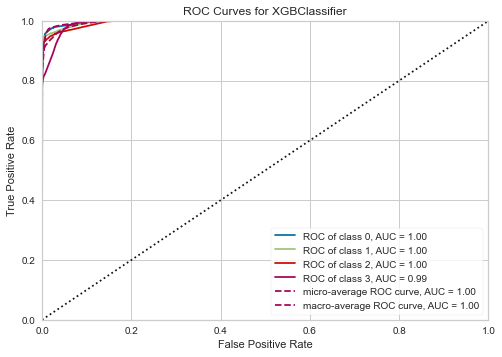

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [28]:
try:
    pc_class.plot_model(finalized_model, "auc")
except:
    print(f"Could not plot model.")

The ‘ROC Curves’ shows that most of the classes achieved the highest possible ROC value of 1.0. Only one class had an ROC value of 0.99, which is normally still considered a good value. It would be prudent to keep in mind that these ROC values might not be achievable in the final web application because:
-	This classifier was produced with thousands of labeled training examples and the web application would receive labels from the user,
-	PyCaret was allowed to choose the best estimator to create the classifier (XGBClassifier in this case), and the final web application might have to limit the type of estimator used because it might have to be less complex (to avoid long wait times for the user) and/ or it might have to be able to be incrementally trained (to enable adaptive information filtering that used the user's input to improve reccomendations).


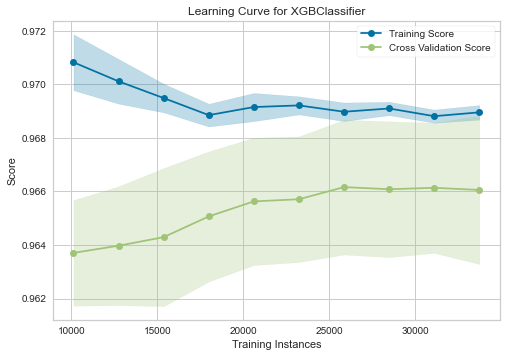

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [29]:
try:
    pc_class.plot_model(finalized_model, "learning")
except:
    print(f"Could not plot model.")

The ‘Learning Curve’ shows how the training process proceeded, in terms of the ‘Training Score’ (indicates how well the model is learning) and the ‘Cross Validation Score’ (indicates how well the model is generalizing), as the number of training examples increased. The higher the score in this chart the better the model is performing.

The ‘Learning Curve’ plot shows that the classifier that was build was not overfitting on the training data. This is normally prevented by using cross-validation (which was performed by PyCaret). If overfitting had occurred the cross-validation scores would be better than the training score (the green line would cross the blue line).

Towards the right side of the plot the green and blue lines are running approximately parallel to each other, this indicates that more training examples would not improve the model. Compare this with the left side of the plot where the two lines are approaching each other indicating that the model was improving.


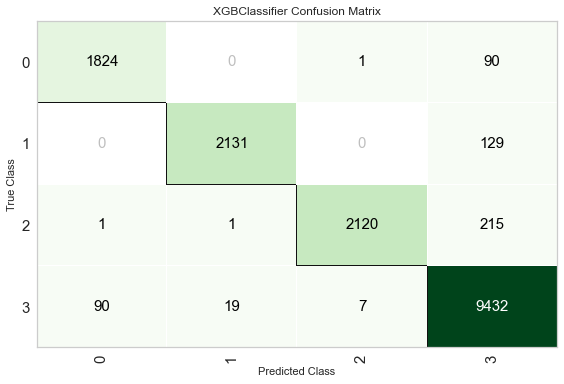

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [30]:
try:
    pc_class.plot_model(finalized_model, "confusion_matrix")
except:
    print(f"Could not plot model.")

The ‘Confusion Matrix’ gives a summary of how well the classifier is performing and in particular shows where the classifier is misclassifying. As an example, the highest misclassification (values not on the main diagonal, from top left to bottom right) occurred for ‘True Class’ 2 (fire) which was incorrectly classified as ‘Predicted Class’ 3 (hurricane) with a value of 215. It is interesting to note that ‘hurricane’ had the highest occurrence in the training data, so it might be beneficial to the model to downsample the ‘hurricane’ example in the training dataset. This downsampling was not performed in this notebook because the classifier performance was considered good enough.

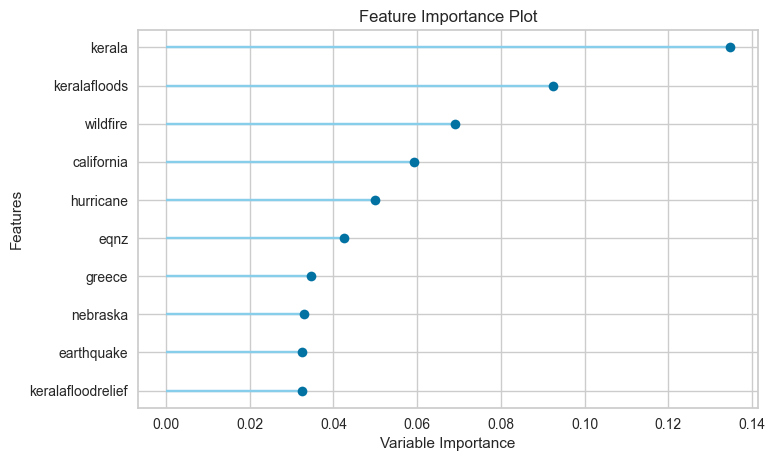

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [31]:
try:
    pc_class.plot_model(finalized_model, "feature")
except:
    print(f"Could not plot model.")

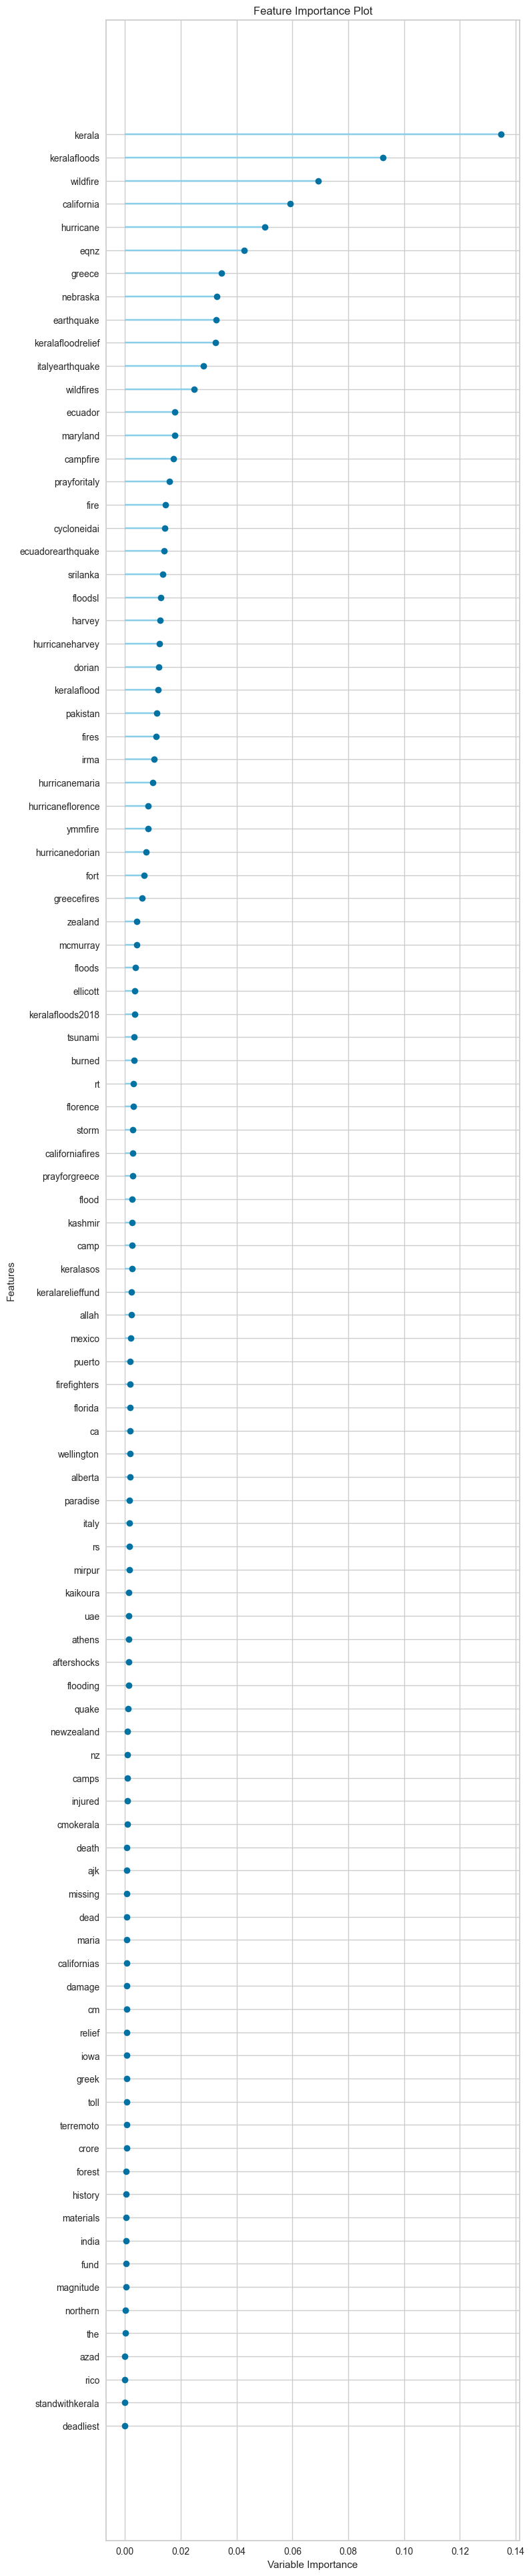

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [32]:
try:
    pc_class.plot_model(finalized_model, "feature_all")
except:
    print(f"Could not plot model.")

The ‘Feature Importance Plot’ shows the features that were important for the classifier to make predictions. The top five were:
1.	‘kerala’
2.	‘keralafloods’
3.	‘wildfire’
4.	‘california’
5.	‘hurricane’

These seem to be reasonable features to be in the top five, because it does appear to provide some information to be able to distinguish between the 4 possible classes (earthquake, fire, flood, hurricane) – flood (‘keralafloods’ and possibly ‘kerala’), fire (‘wildfire’), and hurricane (‘hurricane’).
These top five features also seem to indicate that some text preprocessing might have been beneficial to the model. For example, ‘keralafloods’ should probably have had ‘kerala’ removed from it. This could indicate that the place ‘kerala’ only appears in the training data set associated with floods and none of the other possible 3 classes.


In [33]:
predictions_train = pc_class.predict_model(finalized_model)
predictions_train

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0))
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9656,0.9952,0.9476,0.9663,0.9654,0.9409,0.9415


,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,...,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,event_type,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,hurricane,0.8868
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,earthquake,earthquake,0.9990
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.8320
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.9999
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,fire,0.9994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,flood,0.9988
16056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,earthquake,0.6454
16057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.9999
16058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,fire,fire,0.9988


The actual label is shown in the column ‘event_type’ and the classifier's predictions are given in the column ‘Label’ and ‘Score’. It can be seen that the predictions in ‘Label’ mostly match the ‘event_type’. The ‘Score’ column gives the classifiers prediction probability – values closer to 1.0 are stronger predictions than lower values.

To understand the classifiers better, the misclassified texts are shown below.



In [34]:
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_columns', 500)

In [35]:
predictions_train_with_text = \
    pd.concat([
                
                predictions_train,
                train_df.iloc[y_test.index.to_list()][["tweet_text"]].reset_index(drop=True),
              ], axis=1)

predictions_train_with_text.head(5)

,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,californias,camp,campfire,camps,cm,cmokerala,crore,cycloneidai,damage,dead,deadliest,death,dorian,earthquake,ecuador,ecuadorearthquake,ellicott,eqnz,fire,firefighters,fires,flood,flooding,floods,floodsl,florence,florida,forest,fort,fund,greece,greecefires,greek,harvey,history,hurricane,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricanemaria,india,injured,iowa,irma,italy,italyearthquake,kaikoura,kashmir,kerala,keralaflood,keralafloodrelief,keralafloods,keralafloods2018,keralarelieffund,keralasos,magnitude,maria,maryland,materials,mcmurray,mexico,mirpur,missing,nebraska,newzealand,northern,nz,pakistan,paradise,prayforgreece,prayforitaly,puerto,quake,relief,rico,rs,rt,srilanka,standwithkerala,storm,terremoto,the,toll,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,event_type,Label,Score,tweet_text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,hurricane,0.8868,Low income flood victims being offered food benefits. -KFOR News
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,earthquake,earthquake,0.9990,"NZStuff: No tsunami threat to New Zealand after 7.3 magnitude earthquake hits off the coast of Fukushima, Japan"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.8320,"Yesterday afternoon, VSL successfully handed over items donated to the victims of the mudslide via our website. Thx!"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.9999,"22,000 packed into shelters in Lee County, Florida ahead of Hurricane Irma"
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,fire,0.9994,"We’re joining hundreds of fellow breweries on #GivingTuesday in brewing Resilience IPA, a beer to support @SierraNevada and their efforts to raise funds for those affected by the Camp Fire in CA."


In [43]:
predictions_train_with_text_misclassification = \
    predictions_train_with_text[predictions_train_with_text[target_column]!=predictions_train_with_text["Label"]].reset_index(drop=True)

predictions_train_with_text_misclassification.head(5)

,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,californias,camp,campfire,camps,cm,cmokerala,crore,cycloneidai,damage,dead,deadliest,death,dorian,earthquake,ecuador,ecuadorearthquake,ellicott,eqnz,fire,firefighters,fires,flood,flooding,floods,floodsl,florence,florida,forest,fort,fund,greece,greecefires,greek,harvey,history,hurricane,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricanemaria,india,injured,iowa,irma,italy,italyearthquake,kaikoura,kashmir,kerala,keralaflood,keralafloodrelief,keralafloods,keralafloods2018,keralarelieffund,keralasos,magnitude,maria,maryland,materials,mcmurray,mexico,mirpur,missing,nebraska,newzealand,northern,nz,pakistan,paradise,prayforgreece,prayforitaly,puerto,quake,relief,rico,rs,rt,srilanka,standwithkerala,storm,terremoto,the,toll,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,event_type,Label,Score,tweet_text
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,hurricane,0.8868,Low income flood victims being offered food benefits. -KFOR News
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,hurricane,0.8585,"Mr. President, at least 9 people have died and more than 6700 structures have been destroyed. Are you concerned for the Americans who lost loved ones, their homes and/or livelihoods?"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.6429,Bags of emergency relief supplies are ready for distribution to #earthquake victims in #Guatemala.
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.6398,Felt an earthquake this morning. Kept asking my friends in the area if they felt it &amp; they said no I must had been going crazy but I wasnt
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,hurricane,0.8585,Would appreciate if you could show same sympathy to human life when people are killed and lynched in the name of cow and holiness..


In [44]:
predictions_train_with_text_misclassification.sort_values(["Score"], ascending=True)#.head(5)

,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,californias,camp,campfire,camps,cm,cmokerala,crore,cycloneidai,damage,dead,deadliest,death,dorian,earthquake,ecuador,ecuadorearthquake,ellicott,eqnz,fire,firefighters,fires,flood,flooding,floods,floodsl,florence,florida,forest,fort,fund,greece,greecefires,greek,harvey,history,hurricane,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricanemaria,india,injured,iowa,irma,italy,italyearthquake,kaikoura,kashmir,kerala,keralaflood,keralafloodrelief,keralafloods,keralafloods2018,keralarelieffund,keralasos,magnitude,maria,maryland,materials,mcmurray,mexico,mirpur,missing,nebraska,newzealand,northern,nz,pakistan,paradise,prayforgreece,prayforitaly,puerto,quake,relief,rico,rs,rt,srilanka,standwithkerala,storm,terremoto,the,toll,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,event_type,Label,Score,tweet_text
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,hurricane,0.3247,"RT @Sthumoe: Omar Farukh, a community leader in Kutapalong camp,said conditions were dire: Now we are in the open air.”"
364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,flood,0.4158,"The record heat, fires, floods &amp; storms pounding us from all sides are getting worse even faster than most climate scientists predicted. The only way to protect ourselves is an emergency #GreenNewDeal to put Americans to work building a sustainable, just, resilient economy."
399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,flood,0.4473,#TerroristNationPakistan So jittery #PakistanArmy expecting false flag operation by #IndianArmy on #Pakistans #terrorist camps. #India does not believe in false flag operations. #India will hit #terrorists wherever they are. हम तो छाती ठोक के कहते हैं कि घर में घुस के मारेंगे!
484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,hurricane,0.4510,"If Im not mistaken, India has an unwritten policy of not accepting aid from foreign governments for disaster relief. I remember reading about this during the 2004 Tsunami relief when the centre at that time refused foreign aid."
458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,earthquake,0.4804,"RT @ReutersAfrica: Cyclone Idai batters #Mo

Looking at the five predictions with the lowest ‘Score’ (the classifier had the least confidence with these predictions), the ‘tweet_text’ and corresponding vectorized representation is shown alongside the true label ‘event_type’ and predicted label ‘Label’. Examining these predictions gives an understanding of the classifier.

As an example, the first record has the text:

*“RT @Sthumoe: Omar Farukh, a community leader in Kutapalong camp,said conditions were dire: Now we are in the open air.”*

And the vectorized representation has the following non-zero entries:

**‘camp’, ‘rt’, ‘the’**

The true label was **‘flood’** and the predicted label was **‘hurricane’**. Looking at this information it can be seen why the classifier did not predict the correct label – there is nothing in the tweet text that mentions a flood and the vectorized text doesn’t have any features related to floods either.

It is interesting to note that ‘the’ and ‘rt’ (Retweet) do not add any information that could be useful to a classifier and thus it might be beneficial to have them removed (in future work) as part of a text pre-processing step.


In [39]:
predictions_test = pc_class.predict_model(finalized_model, data=test_vectorized_event_type_df)
predictions_test

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0))
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,aftershocks,ajk,alberta,allah,athens,azad,burned,ca,california,californiafires,californias,camp,campfire,camps,cm,cmokerala,crore,cycloneidai,damage,dead,deadliest,death,dorian,earthquake,ecuador,ecuadorearthquake,ellicott,eqnz,fire,firefighters,fires,flood,flooding,floods,floodsl,florence,florida,forest,fort,fund,greece,greecefires,greek,harvey,history,hurricane,hurricanedorian,hurricaneflorence,hurricaneharvey,hurricanemaria,india,injured,iowa,irma,italy,italyearthquake,kaikoura,kashmir,kerala,keralaflood,keralafloodrelief,keralafloods,keralafloods2018,keralarelieffund,keralasos,magnitude,maria,maryland,materials,mcmurray,mexico,mirpur,missing,nebraska,newzealand,northern,nz,pakistan,paradise,prayforgreece,prayforitaly,puerto,quake,relief,rico,rs,rt,srilanka,standwithkerala,storm,terremoto,the,toll,tsunami,uae,wellington,wildfire,wildfires,ymmfire,zealand,tweet_id,tweet_text,event_type,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,798274825441538048,The earthquake in New Zealand was massive. Billions of dollars of damage. And it was followed by a storm.,earthquake,earthquake,0.9387
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the quake damage to this building. Keep well clear!,earthquake,hurricane,0.9127
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF NZ?! They seem to be happening an awful lot. Stay safe everyone xx #eqnz,earthquake,earthquake,0.9997
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,798434862830993408,"When theres an actual earthquake, landslide and severe flooding during your driving test and you still pass #eqnz #Wellington @NZTAWgtn",earthquake,earthquake,0.9982
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, be safe people, move to higher ground! #eqnz",earthquake,earthquake,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [40]:
end_time = datetime.now()
end_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/04 08:55:07'

In [41]:
duration = end_time - start_time
print("duration :", duration)

duration : 0:29:02.040651
